In [3]:
# Debugging cell to check available files and dataset exploration
!dir fdata

# Print a few example filenames to verify their structure
print("\nExample filenames:")
for device_id in range(1, 4):
    files = sorted([f for f in os.listdir("fdata") if f.startswith(f"{device_id}.")][:2])
    for file in files:
        print(f"- {file}")

# Check attack labels mapping
print("\nAttack Labels Mapping:")
for k, v in ATT_LABEL.items():
    print(f"{k} -> {v} ({ATTACK_NAMES[v]})")

 Volume in drive C is Windows
 Volume Serial Number is C65D-9667

 Directory of c:\Users\karthik cse\PycharmProjects\MegaProject\fdata

07-04-2025  00:57    <DIR>          .
03-06-2025  16:59    <DIR>          ..
18-01-2020  02:08        46,537,568 1.benign.csv
18-01-2020  02:08       105,833,909 1.gafgyt.combo.csv
18-01-2020  02:09        49,322,665 1.gafgyt.junk.csv
18-01-2020  02:09        40,177,901 1.gafgyt.scan.csv
18-01-2020  02:09        51,866,227 1.gafgyt.tcp.csv
18-01-2020  02:09        59,597,256 1.gafgyt.udp.csv
18-01-2020  02:09       135,498,914 1.mirai.ack.csv
18-01-2020  02:09       107,510,905 1.mirai.scan.csv
18-01-2020  02:09       164,633,193 1.mirai.syn.csv
18-01-2020  02:09       315,304,260 1.mirai.udp.csv
18-01-2020  02:10       120,365,536 1.mirai.udpplain.csv
18-01-2020  02:10        13,953,719 2.benign.csv
18-01-2020  02:10        94,251,568 2.gafgyt.combo.csv
18-01-2020  02:10        51,673,314 2.gafgyt.junk.csv
18-01-2020  02:10        37,108,696 2.gafgyt.

# IoT Malware Detection: Multi-Device Analysis

This notebook trains a neural network model on malware data collected from multiple IoT devices. We'll:
1. Load data from 3 different devices (IDs 1, 2, 3)
2. Sample 30% of data from each attack type for each device
3. Combine all data into a single dataset and shuffle
4. Train a neural network model for 10 epochs
5. Evaluate performance and visualize results

The attack types are labeled as follows:
- 0: Benign (normal traffic)
- 1: Gafgyt Combo
- 2: Gafgyt Junk
- 3: Gafgyt TCP
- 4: Gafgyt UDP
- 5: Mirai ACK
- 6: Mirai Scan
- 7: Mirai SYN
- 8: Mirai UDP
- 9: Mirai UDPPlain

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random
from model import MalwareNetSmall  # Import the model from our existing file

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [4]:
# Configure attack labels
ATT_LABEL = {
    '1.gafgyt.combo.csv': 1,
    '1.gafgyt.junk.csv': 2,
    '1.gafgyt.tcp.csv': 3,
    '1.gafgyt.udp.csv': 4,
    '1.mirai.ack.csv': 5,
    '1.mirai.scan.csv': 6,
    '1.mirai.syn.csv': 7,
    '1.mirai.udp.csv': 8,
    '1.mirai.udpplain.csv': 9
}

# Map numbers to attack names for better interpretability
ATTACK_NAMES = {
    0: "Benign",
    1: "Gafgyt Combo",
    2: "Gafgyt Junk",
    3: "Gafgyt TCP",
    4: "Gafgyt UDP",
    5: "Mirai ACK",
    6: "Mirai Scan",
    7: "Mirai SYN",
    8: "Mirai UDP",
    9: "Mirai UDPPlain"
}

In [6]:
# Display available data files
print("Available files in fdata directory:")
files = os.listdir("fdata")

# Filter files that start with a digit and extract device IDs
device_files = [f for f in files if f[0].isdigit() and '.' in f]
device_ids = sorted(list(set([int(file.split('.')[0]) for file in device_files])))

print(f"Found data for device IDs: {device_ids}")
print(f"Total files: {len(files)}, Device-related files: {len(device_files)}")

# Examine a few files
print("\nSample device files:")
for i, file in enumerate(sorted(device_files)):
    if i < 15:  # Show first 15 files
        print(f"- {file}")
    else:
        break

# Check for any non-device files
non_device_files = [f for f in files if f not in device_files]
if non_device_files:
    print("\nNon-device files in the fdata directory:")
    for file in non_device_files[:5]:  # Show at most 5 such files
        print(f"- {file}")
    if len(non_device_files) > 5:
        print(f"  ... and {len(non_device_files) - 5} more")

Available files in fdata directory:
Found data for device IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9]
Total files: 93, Device-related files: 89

Sample device files:
- 1.benign.csv
- 1.gafgyt.combo.csv
- 1.gafgyt.junk.csv
- 1.gafgyt.scan.csv
- 1.gafgyt.tcp.csv
- 1.gafgyt.udp.csv
- 1.mirai.ack.csv
- 1.mirai.scan.csv
- 1.mirai.syn.csv
- 1.mirai.udp.csv
- 1.mirai.udpplain.csv
- 2.benign.csv
- 2.gafgyt.combo.csv
- 2.gafgyt.junk.csv
- 2.gafgyt.scan.csv

Non-device files in the fdata directory:
- data_summary.csv
- device_info.csv
- features.csv
- README.md


## Data Loading Function
First, we'll define a function to load data from multiple devices and attack types, sampling 30% from each combination.

In [7]:
def load_and_sample_data(device_ids=[1, 2, 3], sample_percentage=0.3):
    """
    Load data from specified devices and attack types, sampling the specified 
    percentage from each combination
    
    Args:
        device_ids: List of device IDs to load data from
        sample_percentage: Percentage of data to sample from each device-attack combination
    
    Returns:
        Tuple of (DataFrame with combined data, input_size for the model)
    """
    print(f"Loading data from devices {device_ids}, sampling {sample_percentage*100}% from each attack type")
    
    # Dictionary to store data by device and attack type
    data_dict = {}
    
    # Track stats for reporting
    total_samples = 0
    sampled_samples = 0
    
    # First pass: collect all data into the dictionary
    for device_id in device_ids:
        # Get all files for this device (ensure the filename starts with device_id followed by a dot)
        device_files = []
        for f in os.listdir("fdata"):
            # Only include files that match the pattern: deviceID.something.csv
            if f.startswith(f"{device_id}.") and f.endswith(".csv"):
                device_files.append(f)
        
        if not device_files:
            print(f"No files found for device {device_id}")
            continue
            
        print(f"Found {len(device_files)} files for device {device_id}")
        
        # Filter out gafgytscan.csv files if needed
        device_files = [f for f in device_files if "gafgytscan.csv" not in f]
        
        # Process each file
        for file_name in device_files:
            # Determine attack type
            if "benign" in file_name.lower():
                attack_type = 0  # Benign
            else:
                attack_type = None
                for key, value in ATT_LABEL.items():
                    # Get the pattern without device ID
                    pattern = key.split('.', 1)[1] if '.' in key else key
                    if pattern in file_name:
                        attack_type = value
                        break
            
            if attack_type is None:
                print(f"Warning: Could not determine attack type for {file_name}. Skipping.")
                continue
            
            # Read data
            file_path = os.path.join("fdata", file_name)
            try:
                df = pd.read_csv(file_path)
                
                # Remove any non-feature columns if they exist
                if 'label' in df.columns:
                    df = df.drop('label', axis=1)
                
                # Store in dictionary
                key = (device_id, attack_type)
                if key not in data_dict:
                    data_dict[key] = df
                else:
                    data_dict[key] = pd.concat([data_dict[key], df], ignore_index=True)
                
                total_samples += len(df)
                
                print(f"Loaded {file_path}: {len(df)} samples, Device {device_id}, {ATTACK_NAMES[attack_type]}")
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
    
    # Check if we have any data
    if not data_dict:
        raise ValueError("No data was loaded. Please check if the specified device IDs exist and have appropriate files.")
    
    # Second pass: sample and combine data
    all_sampled_data = []
    attack_sample_counts = {}
    
    for (device_id, attack_type), df in data_dict.items():
        # Sample 30% of the data
        n_samples = max(1, int(len(df) * sample_percentage))  # Ensure at least 1 sample
        sampled_df = df.sample(n=n_samples, random_state=42)
        
        # Add label column
        sampled_df['label'] = attack_type
        
        # Add device_id column for analysis
        sampled_df['device_id'] = device_id
        
        # Track statistics
        sampled_samples += len(sampled_df)
        
        # Track count by attack type
        if attack_type not in attack_sample_counts:
            attack_sample_counts[attack_type] = len(sampled_df)
        else:
            attack_sample_counts[attack_type] += len(sampled_df)
        
        # Add to combined data
        all_sampled_data.append(sampled_df)
    
    # Combine all sampled data
    combined_df = pd.concat(all_sampled_data, ignore_index=True)
    
    # Get input size for model
    input_size = combined_df.shape[1] - 2  # Subtract label and device_id columns
    
    # Print statistics
    print(f"\nTotal original samples: {total_samples}")
    print(f"Total sampled samples: {sampled_samples} ({sampled_samples/total_samples*100:.2f}%)")
    print(f"Input feature size: {input_size}")
    print("\nSamples per attack type:")
    for attack_type, count in sorted(attack_sample_counts.items()):
        print(f"- {ATTACK_NAMES[attack_type]}: {count} samples")
    
    return combined_df, input_size

In [8]:
# Load and sample data from devices 1, 2, and 3
combined_data, input_size = load_and_sample_data(device_ids=[1, 2, 3], sample_percentage=0.3)

# Shuffle the data
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Combined data shape after shuffling: {combined_data.shape}")

# Display a few rows
combined_data.head()

Loading data from devices [1, 2, 3], sampling 30.0% from each attack type
Found 11 files for device 1
Loaded fdata\1.benign.csv: 49548 samples, Device 1, Benign
Loaded fdata\1.benign.csv: 49548 samples, Device 1, Benign
Loaded fdata\1.gafgyt.combo.csv: 59718 samples, Device 1, Gafgyt Combo
Loaded fdata\1.gafgyt.combo.csv: 59718 samples, Device 1, Gafgyt Combo
Loaded fdata\1.gafgyt.junk.csv: 29068 samples, Device 1, Gafgyt Junk
Loaded fdata\1.gafgyt.junk.csv: 29068 samples, Device 1, Gafgyt Junk
Loaded fdata\1.gafgyt.tcp.csv: 92141 samples, Device 1, Gafgyt TCP
Loaded fdata\1.gafgyt.tcp.csv: 92141 samples, Device 1, Gafgyt TCP
Loaded fdata\1.gafgyt.udp.csv: 105874 samples, Device 1, Gafgyt UDP
Loaded fdata\1.gafgyt.udp.csv: 105874 samples, Device 1, Gafgyt UDP
Loaded fdata\1.mirai.ack.csv: 102195 samples, Device 1, Mirai ACK
Loaded fdata\1.mirai.ack.csv: 102195 samples, Device 1, Mirai ACK
Loaded fdata\1.mirai.scan.csv: 107685 samples, Device 1, Mirai Scan
Loaded fdata\1.mirai.scan.csv:

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,label,device_id
0,47.565020,60.167135,7.994532,65.632450,60.248653,11.873462,201.600293,60.167845,7.973368,2249.894043,...,0.0,1.000000,60.0,0.000000,60.000000,0.000000e+00,0.0,0.0,6,1
1,150.773653,74.078244,1.995378,257.483669,74.077928,4.271203,791.125599,74.163203,29.948025,7864.871496,...,0.0,1.687046,74.0,0.000001,95.268043,1.818989e-12,0.0,0.0,1,3
2,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.0,1.000000,60.0,0.000000,60.000000,0.000000e+00,0.0,0.0,3,1
3,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.0,1.000000,60.0,0.000000,60.000000,0.000000e+00,0.0,0.0,4,3
4,102.990373,315.977138,60911.995121,166.058035,353.747231,58763.379077,532.750237,393.629491,53292.640684,5647.087359,...,0.0,29860.100710,554.0,0.000030,554.000000,8.731149e-10,0.0,0.0,9,2


C:\Users\karthik cse\AppData\Local\Temp\ipykernel_17688\1732426789.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


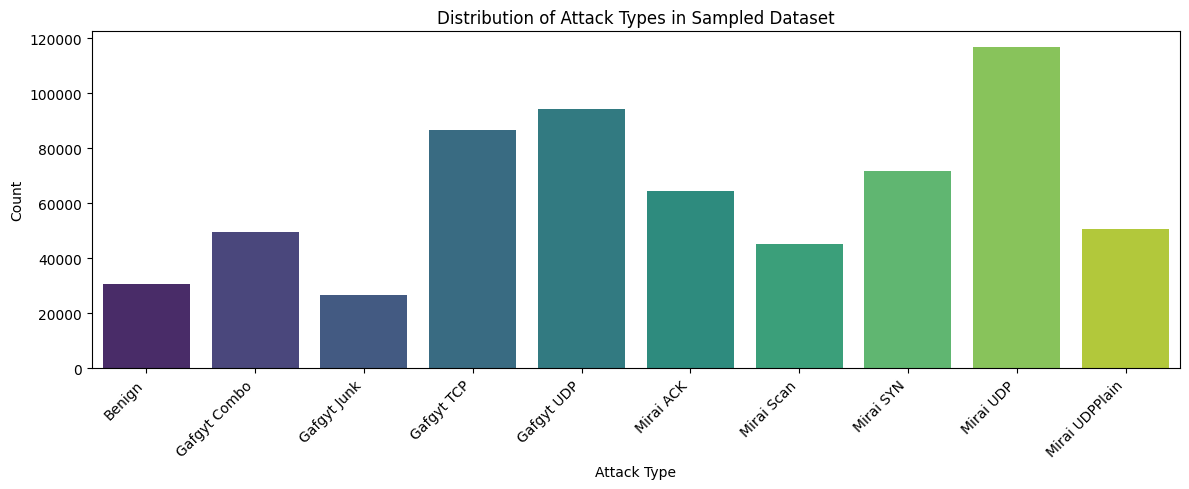

<Figure size 1200x500 with 0 Axes>

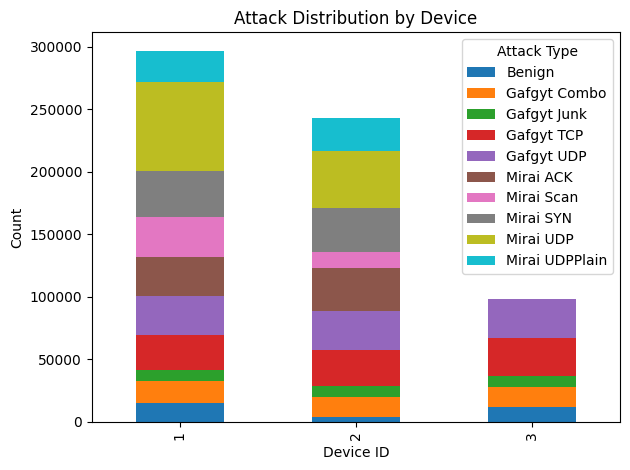

In [9]:
# Analyze the class distribution
plt.figure(figsize=(12, 5))
class_counts = combined_data['label'].value_counts().sort_index()

# Plot with attack names
attack_names = [ATTACK_NAMES[i] for i in class_counts.index]
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.xticks(range(len(attack_names)), attack_names, rotation=45, ha='right')
plt.title('Distribution of Attack Types in Sampled Dataset')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Distribution by device
plt.figure(figsize=(12, 5))
device_counts = combined_data.groupby(['device_id', 'label']).size().unstack()
device_counts.plot(kind='bar', stacked=True)
plt.title('Attack Distribution by Device')
plt.xlabel('Device ID')
plt.ylabel('Count')
plt.legend(title='Attack Type', labels=[ATTACK_NAMES[i] for i in range(10)])
plt.tight_layout()
plt.show()

C:\Users\karthik cse\AppData\Local\Temp\ipykernel_17688\1807019982.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


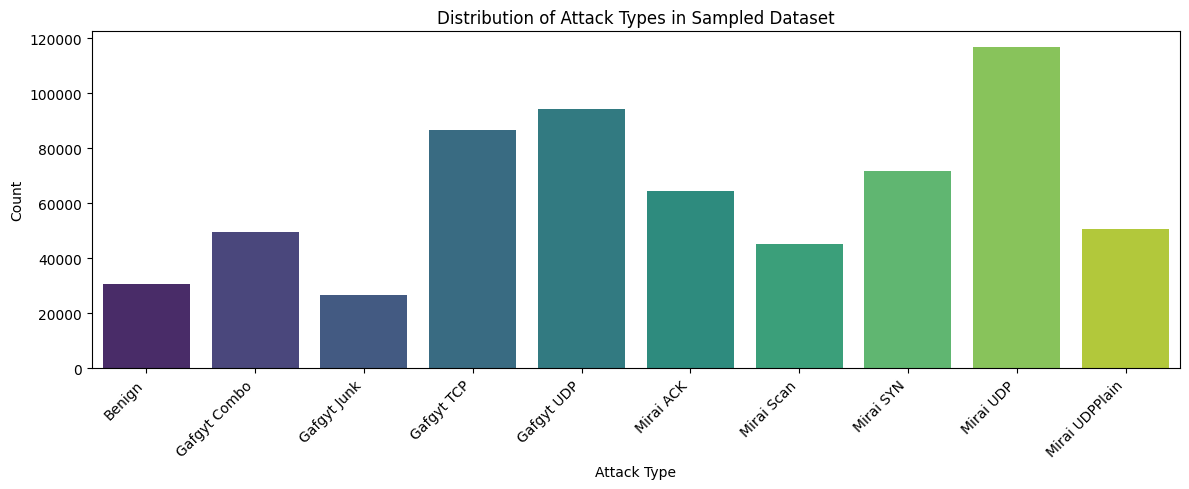

<Figure size 1200x500 with 0 Axes>

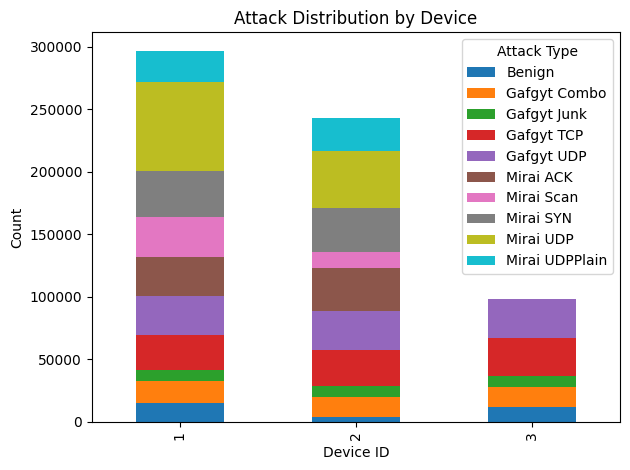

In [10]:
# Check if the combined_data is empty or None
if combined_data is None or combined_data.empty:
    print("No data was loaded. Please check the load_and_sample_data function.")
else:
    # Analyze the class distribution
    plt.figure(figsize=(12, 5))
    class_counts = combined_data['label'].value_counts().sort_index()
    
    # Plot with attack names
    attack_names = [ATTACK_NAMES[i] for i in class_counts.index]
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.xticks(range(len(attack_names)), attack_names, rotation=45, ha='right')
    plt.title('Distribution of Attack Types in Sampled Dataset')
    plt.xlabel('Attack Type')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    # Distribution by device
    plt.figure(figsize=(12, 5))
    device_counts = combined_data.groupby(['device_id', 'label']).size().unstack(fill_value=0)
    device_counts.plot(kind='bar', stacked=True)
    plt.title('Attack Distribution by Device')
    plt.xlabel('Device ID')
    plt.ylabel('Count')
    plt.legend(title='Attack Type', labels=[ATTACK_NAMES[i] for i in sorted(combined_data['label'].unique())])
    plt.tight_layout()
    plt.show()

## Data Preprocessing
Now we'll preprocess the data by:
1. Separating features and labels
2. Normalizing the features using StandardScaler
3. Splitting into training and testing sets
4. Converting to PyTorch tensors

In [11]:
# Prepare data for training
def preprocess_data(df):
    """Preprocess data for training"""
    # Separate features and labels
    X = df.drop(['label', 'device_id'], axis=1)
    y = df['label']
    
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train.values)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test.values)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)
    
    return train_loader, test_loader, X_train.shape[1]

# Preprocess the data
train_loader, test_loader, feature_dim = preprocess_data(combined_data)

Training set: (509801, 115), Test set: (127451, 115)


## Model Training
Now we'll define functions to train and evaluate our model, then train it for 10 epochs.

In [17]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create model with improved architecture
model = MalwareNetSmall(input_size=feature_dim, num_classes=10).to(device)
print(model)

# Define improved loss function for better handling of class imbalance
# Calculate class weights if there's class imbalance
class_counts = combined_data['label'].value_counts().sort_index()
num_samples = len(combined_data)
class_weights = torch.tensor([num_samples / (class_counts[i] * len(class_counts)) 
                             for i in range(10)], dtype=torch.float32).to(device)
print("Class weights:", class_weights)

# Implement Focal Loss to better handle class imbalance and hard examples
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Use Focal Loss with class weights for a powerful combination
criterion = FocalLoss(weight=class_weights, gamma=2.0)

# Improved optimizer with higher learning rate and proper weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.003, weight_decay=1e-4, betas=(0.9, 0.999))

# Better learning rate scheduler with warmup and cosine annealing
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                        max_lr=0.01,  # Higher max learning rate
                                        steps_per_epoch=len(train_loader), 
                                        epochs=20,
                                        pct_start=0.1,  # Warmup for 10% of training
                                        div_factor=25,  # Initial lr = max_lr/25
                                        final_div_factor=1000)  # Final lr = max_lr/1000

Using device: cpu
MalwareNetSmall(
  (layer1): Sequential(
    (0): Linear(in_features=115, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (output): Linear(in_features=32, out_features=10, bias=True)
)
Class weights: tensor([2.0875, 1.2816, 2.3821, 0.7358, 0.6752, 0.9858, 1.4079, 0.8874, 0.5459,
        1.2543])


In [21]:
# Training and evaluation functions
# Fix the train_one_epoch function to properly accept the scheduler parameter
def train_one_epoch(model, loader, optimizer, criterion, device, scheduler=None):
    """Train for one epoch with improved techniques"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad(set_to_none=True)  # More efficient gradient clearing
        
        # Mixup data augmentation for better generalization
        # This creates new training samples by mixing input samples
        if np.random.random() > 0.5:  # Apply mixup 50% of the time
            lam = np.random.beta(0.2, 0.2)  # Beta distribution for mixing coefficient
            batch_size = inputs.size(0)
            index = torch.randperm(batch_size).to(device)
            
            # Mix inputs and targets
            mixed_inputs = lam * inputs + (1 - lam) * inputs[index]
            
            # Forward pass with mixed inputs
            outputs = model(mixed_inputs)
            
            # Calculate mixed loss
            loss = lam * criterion(outputs, targets) + (1 - lam) * criterion(outputs, targets[index])
        else:
            # Standard forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        
        # Backward + optimize
        loss.backward()
        
        # Gradient clipping to stabilize training
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Update learning rate if using OneCycleLR scheduler
        if scheduler is not None and isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
            scheduler.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc



def evaluate(model, loader, criterion, device):
    """Evaluate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # Store predictions and targets for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_targets

In [24]:
import torch.nn.functional as F

# Train the model with improved techniques
num_epochs = 20  # Increased epochs for better convergence
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0
patience_counter = 0
patience = 3  # Early stopping patience

# Create a directory for model checkpoints if it doesn't exist
import os
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

print(f"Starting training for {num_epochs} epochs...")
for epoch in range(num_epochs):
    # Train with the improved function passing scheduler for OneCycleLR
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, scheduler)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate
    val_loss, val_acc, preds, targets = evaluate(model, test_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'checkpoints/best_iot_malware_model.pth')
        patience_counter = 0
        print(f"New best model saved with validation accuracy: {val_acc:.4f}")
    else:
        patience_counter += 1
    
    # Don't use scheduler.step() here since we're using OneCycleLR which steps inside train_one_epoch
    # The scheduler is already stepped in train_one_epoch for each batch
    
    # Print stats with current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"LR: {current_lr:.6f}")
    
    # Early stopping if we reach 95% accuracy
    if val_acc > 0.95:
        print(f"Reached target accuracy of >95%. Early stopping at {val_acc:.4f}")
        break
        
    # Early stopping if no improvement
    if patience_counter >= patience and epoch > 10:  # Ensure we train for at least 10 epochs
        print(f"Early stopping triggered. No improvement for {patience} epochs.")
        break

print("Training complete!")

# Load best model for final evaluation
best_model_path = 'checkpoints/best_iot_malware_model.pth'
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")

# Save the final model
torch.save(model.state_dict(), 'iot_malware_model.pth')
print("Final model saved to 'iot_malware_model.pth'")

Starting training for 20 epochs...
New best model saved with validation accuracy: 0.7013
Epoch 1/20 - Train Loss: 0.5259, Train Acc: 0.4878 | Val Loss: 0.1072, Val Acc: 0.7013 | LR: 0.005202
New best model saved with validation accuracy: 0.7495
Epoch 2/20 - Train Loss: 0.2525, Train Acc: 0.5475 | Val Loss: 0.0963, Val Acc: 0.7495 | LR: 0.010000
Epoch 3/20 - Train Loss: 0.2365, Train Acc: 0.5526 | Val Loss: 0.0949, Val Acc: 0.7291 | LR: 0.009924
Epoch 4/20 - Train Loss: 0.2222, Train Acc: 0.5731 | Val Loss: 0.0812, Val Acc: 0.7493 | LR: 0.009698
New best model saved with validation accuracy: 0.7637
Epoch 5/20 - Train Loss: 0.2213, Train Acc: 0.5768 | Val Loss: 0.0762, Val Acc: 0.7637 | LR: 0.009330
New best model saved with validation accuracy: 0.8031
Epoch 6/20 - Train Loss: 0.2064, Train Acc: 0.5847 | Val Loss: 0.0784, Val Acc: 0.8031 | LR: 0.008830
Epoch 7/20 - Train Loss: 0.1934, Train Acc: 0.5970 | Val Loss: 0.0742, Val Acc: 0.7358 | LR: 0.008214
Epoch 8/20 - Train Loss: 0.1924, Tr

## Results Visualization
Now let's visualize our training results and evaluate the model's performance.

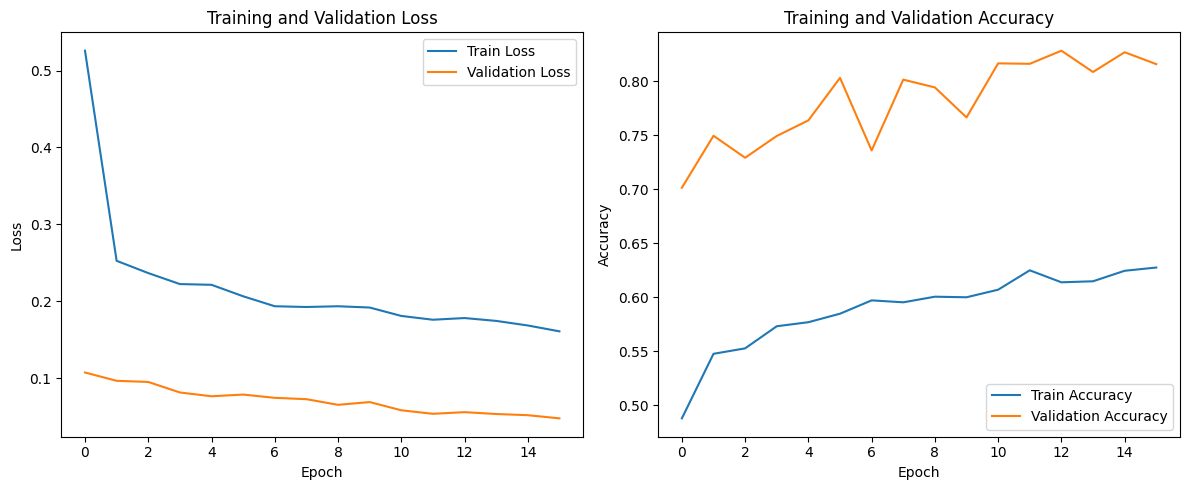

In [25]:
# Plot training and validation metrics
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

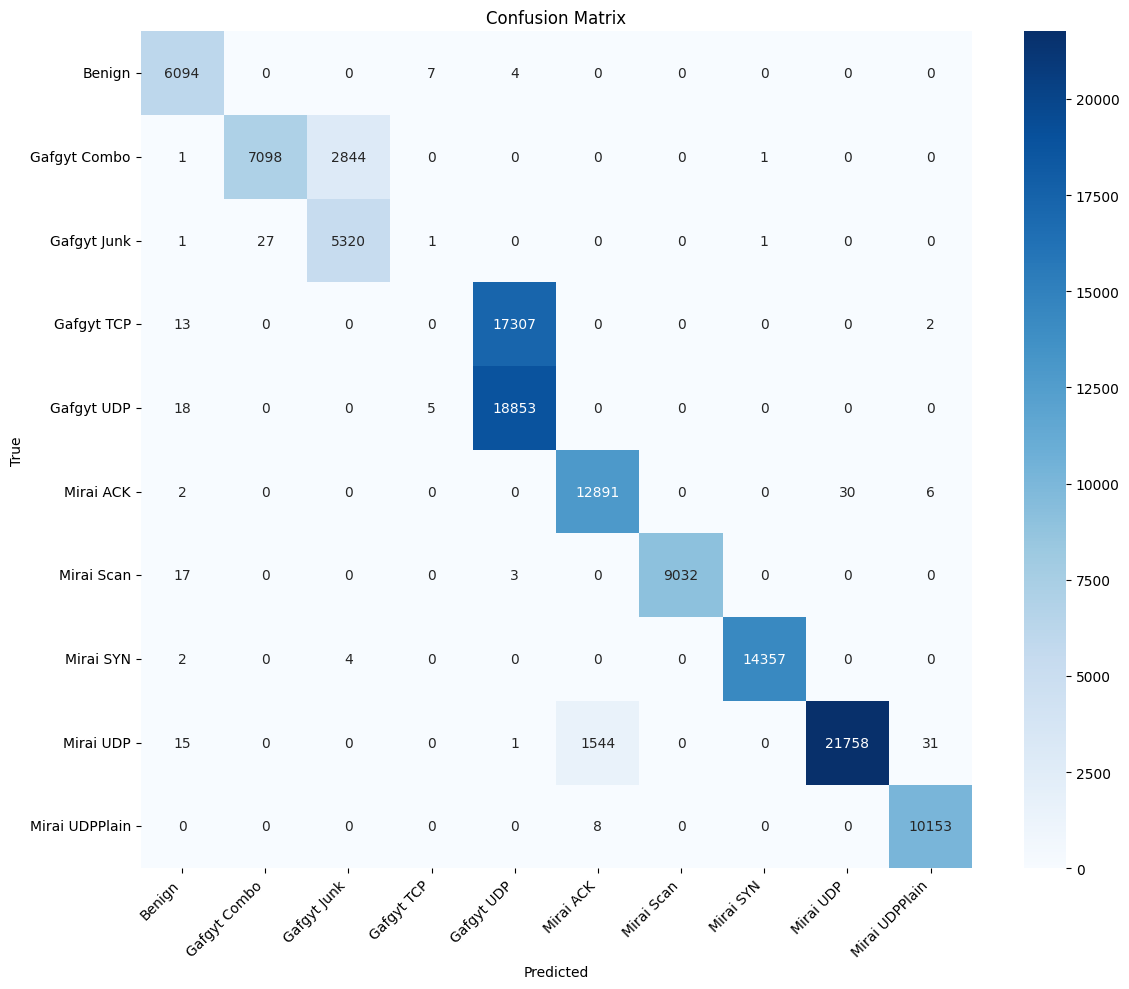

In [26]:
# Get final predictions for confusion matrix
_, _, y_pred, y_true = evaluate(model, test_loader, criterion, device)

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=[ATTACK_NAMES[i] for i in range(10)],
            yticklabels=[ATTACK_NAMES[i] for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [27]:
# Generate classification report
report = classification_report(y_true, y_pred, 
                              target_names=[ATTACK_NAMES[i] for i in range(10)],
                              output_dict=True)

# Convert to DataFrame for better display
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Benign,0.988804,0.998198,0.993479,6105.000000
Gafgyt Combo,0.996211,0.713797,0.831683,9944.000000
Gafgyt Junk,0.651322,0.994393,0.787099,5350.000000
Gafgyt TCP,0.000000,0.000000,0.000000,17322.000000
Gafgyt UDP,0.521262,0.998782,0.685016,18876.000000
Mirai ACK,0.892543,0.997061,0.941911,12929.000000
Mirai Scan,1.000000,0.997791,0.998894,9052.000000
Mirai SYN,0.999861,0.999582,0.999721,14363.000000
Mirai UDP,0.998623,0.931860,0.964087,23349.000000
Mirai UDPPlain,0.996173,0.999213,0.997691,10161.000000
